# TDP Inference in Regression - OHBM 2023
## Beyond Blobology: Advances in Statistical Inference for Neuroimaging

In this practical you will learn how to perform TDP inference in general linear models. 

## Set Up

#### Import the required python packages.

In [2]:
import numpy as np
import numpy.matlib as npm
import matplotlib.pyplot as plt 

import sanssouci as ss

import pyperm as pr

#### Initialize the example

In [25]:
# Set the dimension of the example and the number of subjects
Dim = (50,50)
N = 100
m = np.prod(Dim)

# Generate the category vector and obtain the corresponding design matrix
from sklearn.utils import check_random_state
rng = check_random_state(101)
categ = rng.choice(3, N, replace = True)
X = pr.group_design(categ)
print(X[0:5,])

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [1]:
# Specify the contrast matrix (here 2 contrasts are chosen)
C = np.array([[1, -1, 0], [0, 1, -1]])

# Calulate the number contrasts
L = C.shape[0]

# Calculate the number of p-values generated (L for each voxels)
npvals = m * L

# Generate a white noise field
# lat_data = pr.wfield(Dim, N)

# Generate a stationary random field with given FWHM
FWHM = 4; lat_data = pr.statnoise(Dim, N, FWHM)

# Plot a sample realization of the noise
plt.imshow(lat_data.field[:, :, 1])  

NameError: name 'np' is not defined

### Add signal to the field

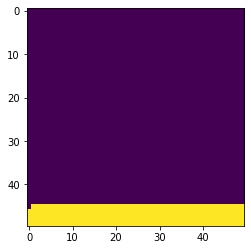

In [8]:
# Obtain the locations where the category is 2
w2 = np.where(categ==2)[0]

# Initialize the spatial signal
pi0 = 0.9  # proportion of noise (true null hypotheses)
p0 = int(np.round(pi0 * m))
signal = np.zeros(m)
signal[(p0 + 1): m] = 0.7
signal = signal.reshape(Dim)

# Add the signal to the field
for I in np.arange(len(w2)):
    lat_data.field[:, :, w2[I]] += signal

# Convert the signal to boolean to determine whether the true signal is
bool_signal = np.zeros(Dim + (L,)) == 0
bool_signal[:, :, 1] = signal > 0 

# Plot the locaion locations for illustration
plt.imshow(signal)


In [9]:
np.std(lat_data.field)

1.0092436950866381

## Posthoc Inference

### Bootstrapping the Data

Bootstrapping is performed using the residuals of the linear model. This gives test-statistics that have the same asymptotic distribution as the limiting test-statistic (under the null). See Eck 2017 and Freedman 1981 for further details. In our context we use these to obtain bootstrapped pivotal statistics which allow us to obtain asymptotic JER control.

In [10]:
# Specify the number of bootstraps to use
B = 100

# Choose the template to use (by default the linear template is chosen)
template = 'linear'

# Run the bootstrapped algorithm (takes a few seconds to run)
minPperm, orig_pvalues, pivotal_stats, bs = pr.boot_contrasts(lat_data, X, C, B, template, True, 1)

(array([51., 22., 10.,  9.,  3.,  1.,  2.,  1.,  0.,  1.]),
 array([2.16960960e-07, 2.30920110e-04, 4.61623259e-04, 6.92326408e-04,
        9.23029557e-04, 1.15373271e-03, 1.38443585e-03, 1.61513900e-03,
        1.84584215e-03, 2.07654530e-03, 2.30724845e-03]),
 <a list of 10 Patch objects>)

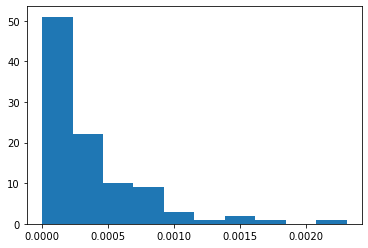

In [11]:
import matplotlib.pyplot as plt 

plt.hist(minPperm)

### Plotting the p-values

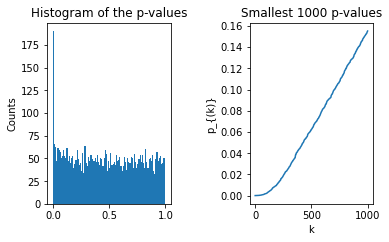

In [12]:
pval_sort_idx = np.argsort(np.ravel(orig_pvalues.field))
pvals = np.ravel(orig_pvalues.field)[pval_sort_idx]

figure, axes = plt.subplots(nrows=1, ncols=2) 
plt.subplot(121)
plt.hist(np.ravel(orig_pvalues.field), 100)
plt.title('Histogram of the p-values')
plt.ylabel('Counts')

plt.subplot(122)
plt.plot(pvals[:np.min([1000, npvals])])
plt.title('Smallest 1000 p-values')
plt.xlabel('k')
plt.ylabel('p_{(k)}')

figure.tight_layout(pad=3.0)

### Lambda Calibration

Using the bootstrapped pivotal_stats that we have calculated we can choose a value lambda that is the (alpha)% quantile (for some 0 < alpha < 1) of the distribution in order to provide asymptotic JER control at a level alpha.

In [13]:
# Choose the confidence level
alpha = 0.1

# Obtain the lambda calibration
lambda_quant = np.quantile(pivotal_stats, alpha)
print('Lambda Quantile:', lambda_quant)

# Calculate the number of voxels in the mask
m = np.sum(lat_data.mask)

# Gives t_k^L(lambda) = lambda*k/npvals for k = 1, ..., npvals
thr = ss.linear_template(lambda_quant, npvals, npvals)

Lambda Quantile: 0.1162633878186714


In [14]:
print(thr)
lambda_quant*(1/5000)

[2.32526776e-05 4.65053551e-05 6.97580327e-05 ... 1.16216882e-01
 1.16240135e-01 1.16263388e-01]


2.3252677563734283e-05

### PostHoc Bound

For a chosen subset of voxels, provide a bound on the number of true null hypotheses within that subset. 

In [17]:
# Get the first 10 pvalues (or any subset of the p-values)
subset_pvals = np.sort(np.ravel(orig_pvalues.field))[:100]

# Compute an upper bound on the number of null hypotheses
bound = ss.max_fp(subset_pvals, thr)
print('FP Upper Bound on subset:', bound)

FP Upper Bound on subset: 64.0


### Confidence Envelopes

In [19]:
# These are the confidence envelopes. I.e. for i = 1:npvals, max_FP[i-1] is the upper bound on the number of 
# false positives that occur within the set [p[0], \dots, p[i-1]] if you were to reject all elements of that set.
max_FP = ss.curve_max_fp(subset_pvals, thr) # Confidence envelope on the chosen subset
print(max_FP)
max_FP = ss.curve_max_fp(pvals, thr) # Confidence envelope on all of them
print(max_FP[0: 10])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  2.  3.  3.  3.  4.  4.  5.  5.  5.  5.  5.  5.  5.  6.  7.  7.  7.  8.
  9.  9.  9. 10. 11. 12. 12. 13. 14. 14. 15. 15. 16. 17. 18. 18. 18. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57. 58. 59. 60. 61. 62. 63. 64.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


#### Plot the FPR and TP curve bounds

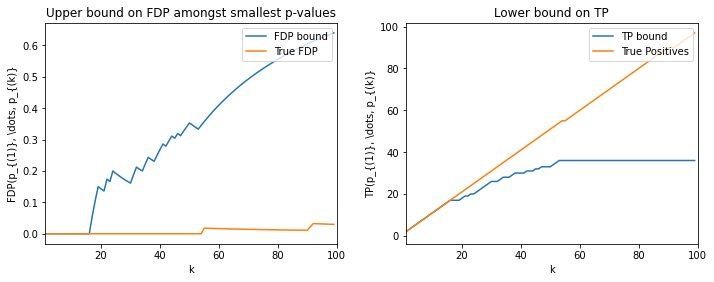

In [20]:
# Generate the vector [0,...,npvals]
one2npvals = np.arange(1, npvals + 1)

# Choose the number of p-values (always the smallest ones first) to plot
lowestnumber = 100

# Ensure that selected number is not greater than the total number of p-values
lowestnumber = np.min([lowestnumber, npvals])

# Dividing the envelope by the number of elements in the set gives a bound on the false discovery proportion
max_FDP = max_FP[0: lowestnumber] / one2npvals[0: lowestnumber] 
min_TP = one2npvals[0: lowestnumber] - max_FP[0: lowestnumber]

# Calculate the truth (to determine if it is correctly bounded!)
sorted_signal = np.ravel(bool_signal)[pval_sort_idx]
TP = np.zeros(lowestnumber)
for I in np.arange(lowestnumber):
    TP[I] = np.sum(sorted_signal[0: I + 1])
    
# Calculate the true FDP for each subset
FP = np.zeros(lowestnumber)
for I in np.arange(lowestnumber):
    FP[I] = np.sum(abs(sorted_signal[0: I + 1] - 1))
true_FDP = FP / one2npvals[0: lowestnumber] 
    
# Initialize the figure
figure = plt.figure(figsize=(10, 4))

# Plot the false discovery proportion and its bound
plt.subplot(121)
plt.plot(max_FDP, label='FDP bound')
plt.plot(true_FDP, label='True FDP')
plt.title('Upper bound on FDP amongst smallest p-values')
plt.xlim(1, lowestnumber)
plt.xlabel('k')
plt.ylabel('FDP(p_{(1)}, \dots, p_{(k)}')
plt.legend(loc="upper right")

# Plot the true postives and their bound
plt.subplot(122)
plt.plot(min_TP, label='TP bound')
plt.plot(TP, label='True Positives')
plt.title('Lower bound on TP')
plt.legend(loc="upper right")
plt.xlim(1, lowestnumber)
plt.xlabel('k')
plt.ylabel('TP(p_{(1)}, \dots, p_{(k)}')
#figure, axes = plt.subplots(nrows=1, ncols=2) 
figure.tight_layout(pad=1.0)

Text(0.5, 1.0, 'Plotting the ordered p-values for each bootstrap')

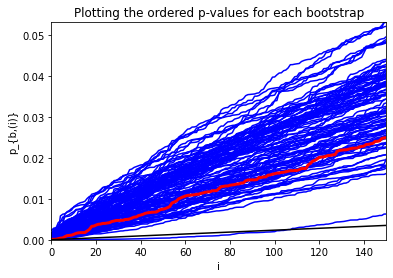

In [21]:
maxbootpval = 0
kmax = 150
kvals = np.arange(kmax)
for b in np.arange(B):
    sorted_bootstraps = np.sort(bs[b,:])
    plt.plot(sorted_bootstraps, color="blue")
    maxbootpval = np.max((maxbootpval, np.max(sorted_bootstraps[:kmax])))
    
# Emphasize a single curve
curve2use = 10
plt.plot(np.sort(bs[curve2use,:]), color="red", linewidth = 3)
    
plt.plot(thr,color="black")
    
plt.xlim(0, kmax)
plt.ylim(0, maxbootpval)
#plt.ylim(0, 0.0005)
plt.xlabel('i')
plt.ylabel('p_{b,(i)}')
plt.title('Plotting the ordered p-values for each bootstrap')


As can be seen we obtain an upper bound on the false discovery proportion and a lower bound on the number of true positives with each set. Note that this bound is valid 95% of the time.

### Bootstrap paths

Text(0.5, 1.0, 'Plotting the ordered p-values for each bootstrap')

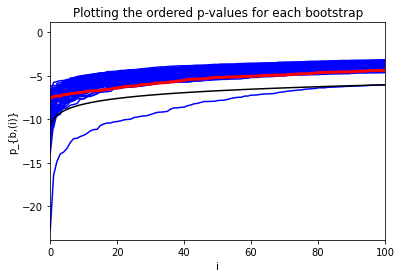

In [15]:
maxbootpval = 0
kmax = 5000
kvals = np.arange(kmax)
for b in np.arange(B):
    sorted_bootstraps = np.sort(bs[b,:])
    plt.plot(np.log(sorted_bootstraps), color="blue")
    maxbootpval = np.max((maxbootpval, np.max(sorted_bootstraps[:kmax])))
    
# Emphasize a single curve
curve2use = 2
plt.plot(np.log(np.sort(bs[curve2use,:])), color="red", linewidth = 3)
    
plt.plot(np.log(thr),color="black")
    
plt.xlim(0, 100)
#plt.ylim(0, maxbootpval)
plt.xlabel('i')
plt.ylabel('p_{b,(i)}')
plt.title('Plotting the ordered p-values for each bootstrap')

In [26]:
_, t_inv, _ = pr.t_ref('linear')
t_inv = ss.inverse_linear_template
ss.get_pivotal_stats(np.sort(bs[1:2,:]), inverse_template=t_inv)

array([0.05736673])

### 3D fMRI Real Data Example

In [ ]:
# Real data directory
real_data_dir = os.path.join(os.getcwd(),'data','example_real_data')

In [ ]:
# Provide Dropbox file URL and Local system path where file needs to be downloaded and extracted.
bold_files, covariates = download_and_extract_zip_from_dropbox(real_data_dir)

This dataset was derived from the Wu-Minn HCP working memory task. Here is some further detail on the task itself.

**The Task**

In the experiment, 77 subjects performed two tasks spread across two runs where each run contained four blocks. During each block, the subject undertook either a 2-back memory task or a 0-back control task. The experimental design was arranged such that, in each run, two blocks were designated to the 2-back memory task, and two blocks were designated to the 0-back control task. In each block a subject was shown a stimuli image (a picture of a face or a place, for instance) and then asked to recall the image they were shown. They were either asked to recall the most recent image (the '0-back' image) or the image shown to them two images prior (the '2-back' image). Interest lies in assessing whether this delay impacted the \%BOLD response.

**First-level Analysis**

In FSL, a first-level analysis has been conducted independently for each subject. In each first-level analysis, the task design was regressed onto Blood Oxygenation Level Dependent (BOLD) response and a Contrast Parameter Estimate (COPE) map was generated. Each COPE map represents, for a given subject, the difference in BOLD response between the subject performing the 2-back task and the 0-back task (e.g $L\hat{\beta}=\hat{\beta}_{\text{2-Back}}-\hat{\beta}_{\text{0-Back}})$).

**Acquisition Details**

All image acquisitions were obtained using a $32$ channel head coil on a modified $3T$ Siemans Skyra scanner via a gradient-echo EPI sequence with TR $=720$ ms, TE $=33.1$ ms, $2.0$ mm slice thickness, $72$ slices, $2.0$ mm isotropic voxels, $208$ mm $\times 180$ mm FOV, and a multi-band acceleration factor of $8$.

**The Data**

You have the COPE map for each subject and the following covariates for each subject, both sorted by subject ID.
 - `Age`: The subject's age.
 - `Sex`: The subject's biological sex, with male encoded as `0` and female encoded as `1`.
 - `PMAT24_A_CR`: The number of correct responses from the Penn Progressive matrices; a measure of the subject's fluid intelligence.
 - `PSQI_Score`: The Pittsburgh Sleep Quality Index; a measure of the subject's quality of sleep.

For more information on these variables, please visit [this link](https://wiki.humanconnectome.org/display/PublicData/HCP-YA+Data+Dictionary-+Updated+for+the+1200+Subject+Release). Here is a brief view of the data.


**The Challenge**

Your challenge is to fit the following model at each voxel $v$ and to provide TDP bounds on selected regions. 

$$Y(v) = \beta_0 + \text{Sex} \beta_1 + \text{Age} \beta_2 + \text{PMAT24_A_CR} \beta_3 + \text{Sex} *\text{PMAT24_A_CR} \beta_4$$

To do so you need to load in the data and run the methods above to obtain a lambda calibration. You can then select subset of the data of your choosing and provide bounds on the number of true postives in each subset.

Feel free to look at the data first. The bounds are valid for any subset, including data-driven ones.


In [7]:
# Real data directory
from crtoolbox.tests.generate_ni_data import *
from data.download import download_and_extract_zip_from_dropbox
real_data_dir = os.path.join(os.getcwd(),'data','example_real_data')

ModuleNotFoundError: No module named 'data'

In [2]:
%pip install numpy
%pip install requests
%pip install crtoolbox

# Basic imports
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

# Imports from Confidence Regions Toolbox
from crtoolbox.generate import generate_CRs

# Import supporting functions
from crtoolbox.lib.set_theory import *
from crtoolbox.lib.boundary import *
from crtoolbox.lib.regression import *
from crtoolbox.lib.cohens import *

# Import data generation
from crtoolbox.tests.generate_2d_data import *
from crtoolbox.tests.generate_ni_data import *

# Import plotting functions
from crtoolbox.lib.display import display_crs, display_volume

# Import data download function
from data.download import download_and_extract_zip_from_dropbox

You should consider upgrading via the 'c:\users\12sda\appdata\local\programs\python\python38-32\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\12sda\appdata\local\programs\python\python38-32\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\12sda\appdata\local\programs\python\python38-32\python.exe -m pip install --upgrade pip' command.


ModuleNotFoundError: No module named 'data'

In [12]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

# Imports from Confidence Regions Toolbox
from crtoolbox.generate import generate_CRs

# Import supporting functions
from crtoolbox.lib.set_theory import *
from crtoolbox.lib.boundary import *
from crtoolbox.lib.regression import *
from crtoolbox.lib.cohens import *

# Import data generation
from crtoolbox.tests.generate_2d_data import *
from crtoolbox.tests.generate_ni_data import *

# Import plotting functions
from crtoolbox.lib.display import display_crs, display_volume

# Import data download function
from data.download import download_and_extract_zip_from_dropbox

ModuleNotFoundError: No module named 'data'